# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [83]:
df = pd.read_csv('previsao_de_renda.csv')

In [84]:
#Verificando as colunas e seus tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

Com a mesma base de códigos anteriores, vamos preparar o nosso DataFrame

In [85]:
#excluindo variáveis irrelevantes para o nosso propósito
df = df.drop(columns=['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1)


In [86]:
#Verificando valores ausentes
missing = df.isnull().sum()
missing

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [87]:
#imputação de mediana dos valores ausentes em tempo_emprego 
mediana_tempo_emprego = df['tempo_emprego'].median()

df['tempo_emprego'] = df['tempo_emprego'].fillna(mediana_tempo_emprego)

In [88]:
#verificando novamente se há valores nuloes
missing_values = df.isnull().sum()
missing_values


sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [89]:
#Verificando a contagem de entradas em cada coluna
df.count()

sexo                     15000
posse_de_veiculo         15000
posse_de_imovel          15000
qtd_filhos               15000
tipo_renda               15000
educacao                 15000
estado_civil             15000
tipo_residencia          15000
idade                    15000
tempo_emprego            15000
qt_pessoas_residencia    15000
renda                    15000
dtype: int64

Agora que excluímos as colunas irrelevantes, imputamos a mediana na coluna 'tempo_emprego' e confirmamos que não há valores ausentes, daremos continuidade em nosso trabalho. Utilizaremos o DataFrame original sem log na variável 'renda'.

**1 - Separe a base em treinamento e teste (25% para teste, 75% para treinamento).**

In [90]:
# Utilizando o One Hot ecoding com drop_first=True para evitar multicolinearidade
df_dummies = pd.get_dummies(df, drop_first=True)

# Utilizando df_dummies para criar X_dummies e y_dummies
X_dummies = df_dummies.drop('renda', axis=1)  
y_dummies = df_dummies['renda']  

# Dividindo os dados em treinamento e teste 75% treinamento e 25% para teste
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(X_dummies, y_dummies, test_size=0.25, random_state=42)



**2 -Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o  𝑅2
  na base de testes. Qual o melhor modelo?**

In [91]:

# Criando lista de alphas
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
results = {}

# Loop for com os alphas escolhidos
for alpha in alphas:
    model = Ridge(alpha=alpha) #Aplicando os alphas por iteração
    model.fit(X_train_dummies, y_train_dummies) #Treinando o modelo com as variáveis dummies
    y_pred = model.predict(X_test_dummies) #Utilizando valores reais com X_test
    r2 = r2_score(y_test_dummies, y_pred) #Comparando os valores reais de y_test_dummies com os previstos pelo modelo (y_pred)
    results[alpha] = r2

# Encontrando o melhor alpha e respectivo R2
best_alpha = max(results, key=results.get)
best_r2 = results[best_alpha]

print("Melhor alpha:", best_alpha)
print("R2 do melhor modelo:", best_r2)


Melhor alpha: 0.1
R2 do melhor modelo: 0.26903183169156664


**3 - Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?**

In [92]:
# Criando um dicionário que conterá os resultados
lasso_results = {}

# Criando um loop for com os mesmos alphas
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=1000)  # Ajustando o modelo LASSO
    lasso_model.fit(X_train_dummies, y_train_dummies)  # Treinando o modelo com as variáveis dummies
    y_pred_lasso = lasso_model.predict(X_test_dummies)  # Fazendo as predições
    r2_lasso = r2_score(y_test_dummies, y_pred_lasso)  # Calculando o R2
    lasso_results[alpha] = r2_lasso  # Armazenando o R2 no dicionário

# Encontrando o melhor alpha para LASSO usando lasso_results
best_alpha_lasso = max(lasso_results, key=lasso_results.get)
best_r2_lasso = lasso_results[best_alpha_lasso]

print("Melhor alpha para LASSO:", best_alpha_lasso)
print("Melhor R^2 para LASSO:", best_r2_lasso)



C:\Users\giova\anaconda3\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\giova\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\giova\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e+11, tolerance: 7.723e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

Melhor alpha para LASSO: 0.1
Melhor R^2 para LASSO: 0.26903823587492204


C:\Users\giova\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.645e+10, tolerance: 7.723e+07
  model = cd_fast.enet_coordinate_descent(


**Com base nos resultados acima, podemos concluir que a regressão Lasso tenha minimamente melhor que o modelo anterior. Em termos práticos, o R2 foi o mesmo: 0.269** 

**4 - Rode um modelo stepwise. Avalie o  𝑅2 na base de testes. Qual o melhor resultado?**

In [93]:
# Aplicando a transformação logarítmica na coluna renda e criando log_renda
df['log_renda'] = np.log(df['renda'])

# Convertendo variáveis categóricas em dummies e excluindo as colunas renda e log_renda para
X = pd.get_dummies(df.drop(columns=['renda', 'log_renda']), drop_first=True)

# Transformando todas as variáveis explicativas em float
X = X.astype(float)

# Definindo y (alvo) como log-renda
y = df['log_renda'].replace([np.inf, -np.inf], np.nan).dropna()

# Função stepwise bidirecional
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # forward step (adicionando variáveis)
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Adicionando {best_feature} com p-valor {best_pval:.6}')
        # backward step (removendo variáveis)
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed = True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print(f' Excluindo {worst_feature} com p-valor {worst_pval:.6}')
        if not changed:
            break
    return included

# Aplicando a seleção stepwise
selected_features = stepwise_selection(X, y)

print('Variáveis selecionadas:', selected_features)


Adicionando tempo_emprego com p-valor 0.0
Adicionando sexo_M com p-valor 0.0
Adicionando tipo_renda_Empresário com p-valor 1.24823e-27
Adicionando educacao_Superior completo com p-valor 3.08154e-22
Adicionando posse_de_imovel com p-valor 9.91579e-15
Adicionando idade com p-valor 5.99025e-07
Adicionando tipo_renda_Pensionista com p-valor 3.68185e-06
Adicionando qtd_filhos com p-valor 0.00125081
Adicionando posse_de_veiculo com p-valor 0.00491135
Adicionando tipo_renda_Servidor público com p-valor 0.00885515
Variáveis selecionadas: ['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'posse_de_imovel', 'idade', 'tipo_renda_Pensionista', 'qtd_filhos', 'posse_de_veiculo', 'tipo_renda_Servidor público']


In [94]:
# Ajustando o modelo final com as variáveis selecionadas
X_final = sm.add_constant(X[selected_features])
model_final = sm.OLS(y, X_final).fit()

print(model_final.summary())



                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     798.2
Date:                Thu, 15 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:59:45   Log-Likelihood:                -16223.
No. Observations:               15000   AIC:                         3.247e+04
Df Residuals:                   14989   BIC:                         3.255e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [95]:
# Avaliando o R2 na base de teste
y_test_log = np.log(y_test_dummies)


est_const = sm.add_constant(X_test_dummies[selected_features])  # Adicionando constante e filtrando pelas variáveis selecionadas
y_pred_test = model_final.predict(est_const)
r2_test = r2_score(y_test_log, y_pred_test)

print(f'R^2 na base de testes: {r2_test}')


R^2 na base de testes: 0.35305621494306305


**Conclusão:**
O R2 ajustado no conjunto de treino foi de 0.347, enquanto no conjunto de testes foi de 0.353. Esses valores são bastante próximos, o que sugere que o modelo tem uma boa capacidade de generalização, sem sinais evidentes de overfitting. Isso é positivo, pois indica que o modelo é capaz de performar de maneira semelhante em dados novos, comparado ao seu desempenho nos dados de treino.

**5 - Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?**

Ao comparar os modelos Ridge e LASSO com o modelo stepwise, observando os resultados de R-quadrado na base de testes, o modelo stepwise se apresentou como o melhor entre os três, apresentando um R-quadrado de 0.353. Esse desempenho superior sugere que ele tem uma capacidade maior de explicar a variabilidade da variável dependente log_renda, em comparação aos modelos Ridge e LASSO, onde ambos registraram um R-quadrado de 0.269. A eficácia do modelo stepwise pode ser atribuída à seleção criterioza de variáveis, que identificou as variáveis com relações mais significativas com a variável alvo. 

**6 - Partindo dos modelos que você ajustou, tente melhorar o  𝑅2 na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.**

In [96]:
#Checando novamente as colunas, tipos de dados e a integridade do DF
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   15000 non-null  object 
 1   posse_de_veiculo       15000 non-null  bool   
 2   posse_de_imovel        15000 non-null  bool   
 3   qtd_filhos             15000 non-null  int64  
 4   tipo_renda             15000 non-null  object 
 5   educacao               15000 non-null  object 
 6   estado_civil           15000 non-null  object 
 7   tipo_residencia        15000 non-null  object 
 8   idade                  15000 non-null  int64  
 9   tempo_emprego          15000 non-null  float64
 10  qt_pessoas_residencia  15000 non-null  float64
 11  renda                  15000 non-null  float64
 12  log_renda              15000 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(5)
memory usage: 1.3+ MB


In [97]:
#Convertendo as variáveis booleanas para integer
df['posse_de_veiculo'] = df['posse_de_veiculo'].astype(int)
df['posse_de_imovel'] = df['posse_de_imovel'].astype(int)

#Aplicando OHE nas variáveis categóricas
df = pd.get_dummies(df, columns=['sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)


In [98]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posse_de_veiculo               15000 non-null  int32  
 1   posse_de_imovel                15000 non-null  int32  
 2   qtd_filhos                     15000 non-null  int64  
 3   idade                          15000 non-null  int64  
 4   tempo_emprego                  15000 non-null  float64
 5   qt_pessoas_residencia          15000 non-null  float64
 6   renda                          15000 non-null  float64
 7   log_renda                      15000 non-null  float64
 8   sexo_M                         15000 non-null  uint8  
 9   tipo_renda_Bolsista            15000 non-null  uint8  
 10  tipo_renda_Empresário          15000 non-null  uint8  
 11  tipo_renda_Pensionista         15000 non-null  uint8  
 12  tipo_renda_Servidor público    15000 non-null 

**Obs:** Com base no resultado acima, concluímos que todas as variáveis estão com os dados corretos para o nosso próximo modelo.

Para proseguirmos com nossa análise, primeiramente exploraremos através de um heatmap quais variáveis seriam mais importantes para explicar a nossa variável alvo (log_renda)

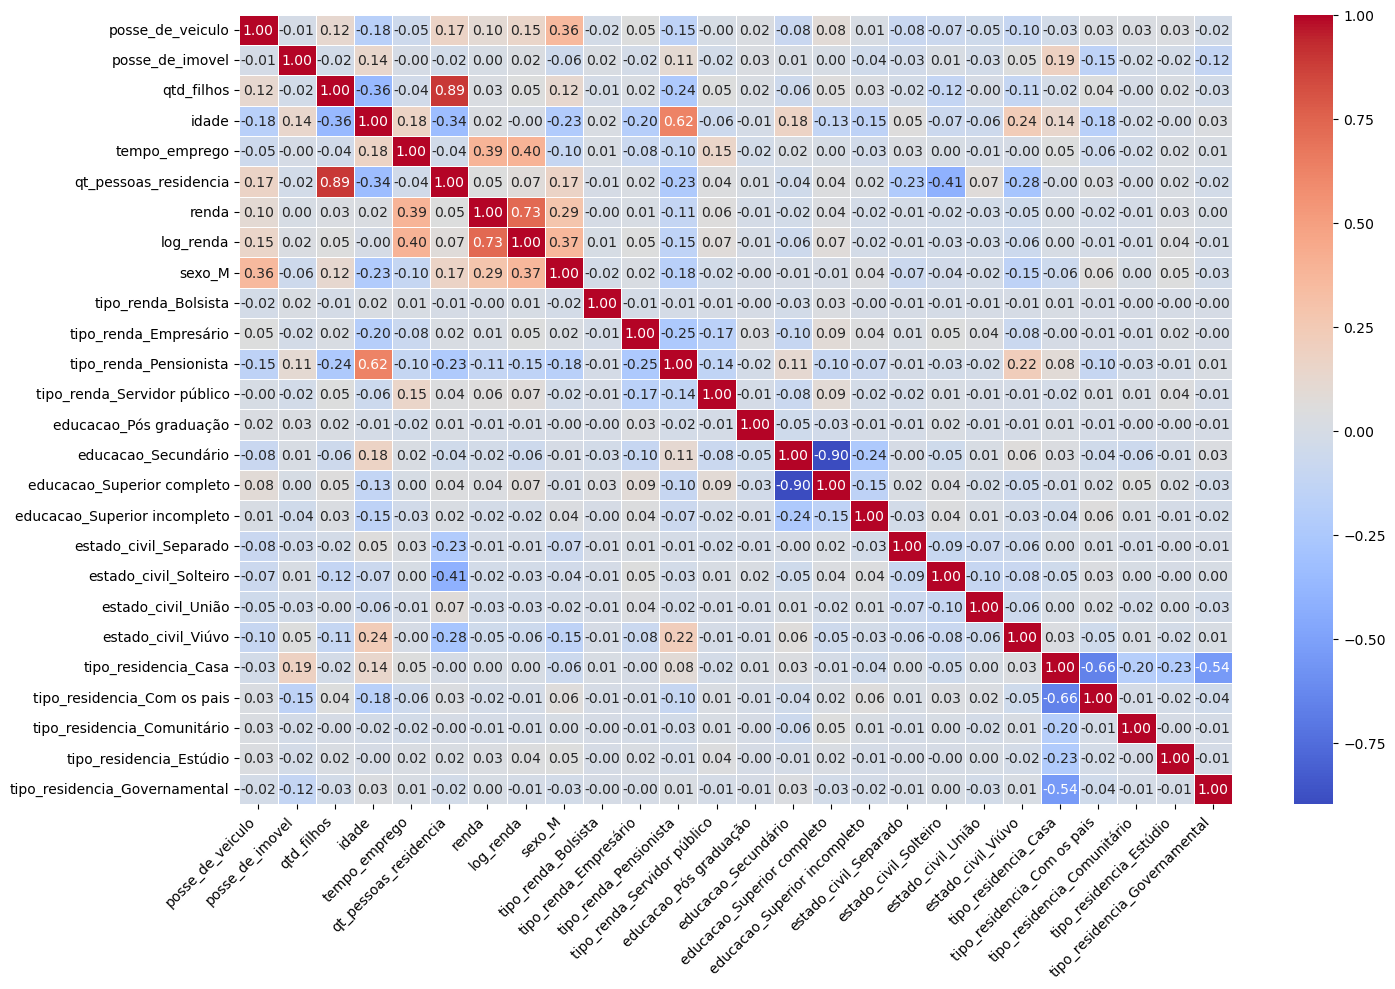

In [113]:
# Calculando a matriz de correlação
corr = df.corr()

plt.figure(figsize=(15, 10))

# Criando o heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Com base na avaliação do heatmap acima, podemos perceber que a variável tempo_emprego é a mais importante para explicar log_renda. Abaixo, ajustaremos essa variável para um formato **Polinomial** e em seguida, verificaremos o R2 resultante do modelo.

Por quê?: Isso é feito porque a relação entre o tempo de emprego e a renda pode não ser estritamente linear. Por exemplo, os primeiros anos de experiência podem ter um impacto maior no aumento da renda do que anos subsequentes. Adicionar termos polinomiais permite que o modelo reflita essas relações curvilíneas.

In [114]:
# Criando termos polinomiais para 'tempo_emprego'
poly = PolynomialFeatures(degree=2, include_bias=False)
tempo_emprego_poly = poly.fit_transform(df[['tempo_emprego']])
# Definindo X e y
X = df.drop(['renda', 'log_renda'], axis=1)
y = df['log_renda']

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Adicionando a constante e ajustando o modelo
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

# Avaliando o modelo na base de testes
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)
r2 = r2_score(y_test, y_pred)

print(f'O R2 atualizado na base de testes é: {r2}')

O R2 atualizado na base de testes é: 0.3510375985702071


**Conclusão:** Com base no resultado acima, percebemos que após ajustar a variável 'tempo_emprego', nosso R2 obteve uma queda mínima (0.3510375985702071) quando comparado ao modelo anterior (0.35305621494306305). Desta forma, concluímos que neste último modelo não conseguirmos melhorar a performance, tecnicamente, os dois modelos posseum resultados idênticos.

Continuando nossa busca pela melhora do R2, utilizaremos o método de Eliminação Recursiva de Atributos - **RFE** - que é configurado com o modelo de **Regressão Linear** como base e é instruído a selecionar as 10 variáveis mais importantes. O argumento step=1 indica que uma variável será removida por iteração.

Por quê?: O objetivo do RFE é simplificar o modelo eliminando progressivamente as variáveis menos importantes, com base no critério de que a remoção da variável menos importante a cada etapa resultará no conjunto ótimo de variáveis que maximiza a performance do modelo.

In [115]:

# Definindo o modelo
model = LinearRegression()

# RFE
selector = RFE(model, n_features_to_select=10, step=1)  # n_features_to_select é o número de variáveis finais desejadas
selector = selector.fit(X_train, y_train)

# Verificando quais variáveis foram selecionadas
selected_columns = X_train.columns[selector.support_]

# Ajustando o modelo com as variáveis selecionadas
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model_selected = model.fit(X_train_selected, y_train)

# Avaliando o modelo na base de testes com as variáveis selecionadas
y_pred_selected = model_selected.predict(X_test_selected)
r2_selected = r2_score(y_test, y_pred_selected)

print(f'Variáveis selecionadas: {selected_columns}')
print(f'R^2 com variáveis selecionadas: {r2_selected}')


Variáveis selecionadas: Index(['qtd_filhos', 'qt_pessoas_residencia', 'sexo_M', 'tipo_renda_Bolsista',
       'educacao_Secundário', 'educacao_Superior incompleto',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_Viúvo',
       'tipo_residencia_Estúdio'],
      dtype='object')
R^2 com variáveis selecionadas: 0.14328438263175214


**Conclusão:** Com base no resultado acima, concluímos que o modelo de Regressão Linear juntamente com o RFE resultou em um R2 bastante inferior se comparado aos nossos modelos anteriores.

**7 - Ajuste uma árvore de regressão e veja se consegue um  𝑅2 melhor com ela.**

In [101]:
# Ajustando uma árvore de decisão ao conjunto de treinamento
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_tree = tree_reg.predict(X_test)

# Calculando o R^2 para a árvore de decisão
r2_tree = r2_score(y_test, y_pred_tree)

r2_tree


0.316708821186088

**Conclusão:** Com base no resultado acima, notamos que o modelo com Árvore de Regressão obteve uma performance pior se comparado ao modelo stewise.

**Conclusão Geral:** Após rodarmos vários modelos, com várias técnicas e transformações, concluímos que para explicar a variável **renda** o modelo que utilizou a abordagem stepwise, ajustado com variáveis selecionadas com base em sua significância estatística, apresentou o melhor desempenho, com um R^2 de 0.35305621494306305 na base de testes.